# Working on probabilistic pairwise

In [1]:
import pandas as pd
import re
import sys 
import os
sys.path.insert(0, os.path.abspath("../"))
from pyanp.pairwise import Pairwise
import pyanp.priority as priority
from numpy import log, exp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.stats import triang,truncnorm

In [3]:
?triang

In [4]:
rv = triang(c=0.5, loc=.1, scale=10)

In [7]:
def make_log_triang(lower=1, mid=2, upper=3):
    loc = log(lower)
    scale = log(upper) - log(lower)
    c = (log(mid)-log(lower))/(log(upper)-log(lower))
    return triang(c=c, loc=loc, scale=scale)

In [8]:
tb = make_log_triang(1, 30, 100)

In [9]:
vals = tb.rvs(20)
evals = [exp(v) for v in vals]
display([evals, vals])

[[29.979306676879666,
  12.10353406499426,
  9.466240085691904,
  2.7071862428073032,
  21.44920309732095,
  12.728816607164271,
  12.765447838546406,
  59.273920662682784,
  7.437114671947961,
  5.4660204955746075,
  37.115332292117074,
  26.839557849337563,
  3.5296504645620232,
  1.5812556247266094,
  7.8383687545386,
  24.009454323094214,
  79.640060578791,
  26.29256106507376,
  49.277953428277534,
  46.330581084652025],
 array([3.40050737, 2.49349748, 2.24773179, 0.99590981, 3.06568749,
        2.54386845, 2.54674213, 4.08216942, 2.00648296, 1.69855084,
        3.61403015, 3.28987684, 1.26119885, 0.45821923, 2.05903075,
        3.17844768, 4.37751724, 3.26928605, 3.89747679, 3.83580224])]

In [10]:
tb.mean()

2.6687891892167492

In [11]:
log(30)

3.4011973816621555

In [12]:
def make_tnorm(myclip_a, myclip_b, my_mean, my_std):
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return truncnorm(a=a, b=b, loc=my_mean, scale=my_std)

def make_tnorm_log(my_mean, my_max):
    delta = log(my_max) - log(my_mean)
    myclip_a = log(my_mean)-delta
    myclip_b = log(my_max)
    return make_tnorm(myclip_a, myclip_b, log(my_mean), 0.5*delta)

In [13]:
tl = make_tnorm(1, 5, 3, 2)

In [14]:
tl.rvs(10)

array([4.626727  , 4.20351139, 4.33349252, 1.14665295, 1.39528508,
       2.90039139, 4.95054783, 2.59732597, 3.16892354, 2.16964349])

In [15]:
ltl = make_tnorm_log(3, 4.5)

In [16]:
[exp(v) for v in ltl.rvs(10)]

[3.0169564353489253,
 2.0887025085734154,
 2.3889224927049195,
 2.8663742954211595,
 3.596227514021629,
 2.7657769324328796,
 3.520895440924603,
 2.469433721923167,
 3.164528017657171,
 2.0120801962836823]

## Try another idea

Let's change our vote world from 1/9 - 9 (or -9...,-2, 1,2,3,...9) into something easier to randomly work with.

Let's [-8, 8] and then if value is < 0, multiply by -1, add 1, and then invert.

Otherwise we just add 1.

We call this L-scale (for linear) and M-scale is the standard multiplication.  We need a converter

In [17]:
def lscale_mscale(val):
    if val < 0:
        val = -val
        val += 1
        val = 1.0/val
        return val
    else:
        return val+1

In [18]:
lscale_mscale(-1)

0.5

In [72]:
class LScaleToMScaleDist:
    def __init__(self, distrib, name):
        self.distrib = distrib
        self.name = name
    
    def rvs(self, size=0):
        rval = self.distrib.rvs(size=size)
        for i in range(len(rval)):
            rval[i] = lscale_mscale(rval[i])
        return rval
    
    def mean(self):
        return lscale_mscale(self.distrib.mean())
    
    def __str__(self):
        return self.name

def plot_sim(rval, alt_names, idealize=False):
    if len(rval.shape) == 1:
        if idealize:
            rval = rval / max(rval)
        df = pd.DataFrame({'alts': alt_names, 'val':rval})
        return  df.plot.bar(x='alts', y='val', rot=0)
    else:
        if idealize:
            rval = (rval.transpose() / rval.max(axis=1)).transpose()
        prisdf = pd.DataFrame(data=rval, columns=alt_names)
        prismean = rval.mean(axis=0)
        print(prismean)
        meandf = pd.DataFrame({'alts':alt_names, 'val':prismean})
        fig, ax = plt.subplots()
        ax2=ax.twiny()
        meandf.plot.bar(x='alts', y='val', alpha=0.6, ax=ax2)
        prisdf.boxplot(ax=ax)
        plt.show()
    
class RPairwiseMatrix:
    def __init__(self, size):
        self.VOTES = [TRI_1, TRI_2,TRI_3, TRI_4, TRI_5, TRI_6, TRI_7, TRI_8, TRI_9]
        self.size = size
        self.matrix = np.empty([size, size], dtype=object)
        for i in range(size):
            self.matrix[i,i] = 1.0
            
    @staticmethod
    def from_lscale_nparray(arr):
        size=len(arr)
        rval = RPairwiseMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row,col] != 0:
                    rval.set_lscale(row, col, arr[row, col])
        return rval
    
    @staticmethod
    def from_mscale_nparray(arr):
        size=len(arr)
        rval = RPairwiseMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row,col] != 0:
                    if arr[row,col] >= 1:
                        rval.set_lscale(row, col, int(np.round(arr[row, col])-1))
                    else:
                        val = 1/arr[row,col]
                        rval.set_lscale(col, row, int(-(np.round(val)-1)))
        return rval
    
    def set_lscale(self, row, col, val):
        if isinstance(val, (int, np.int, np.int16, np.int32, np.int64)):
            if val < 0:
                tmp = row
                row = col
                col = tmp
                val = -val
            data = self.VOTES[val - 1]
            self.matrix[row,col]=data
            self.matrix[col,row] = None
        elif isinstance(val, (float, np.float, np.float16, np.float32, np.float64, np.float128)):
            if val < 0:
                tmp = row
                row = col
                col = tmp
                val = -val
            self.matrix[row, col] = triang(c=0.5, loc=(val-1.5), scale=3)
            self.matrix[col,row] = None
        else:
            raise Exception("Unknown type "+type(val))
        
    def sim(self, size=1):
        if size > 1:
            # We want a list of these things
            return [self.sim(size=1) for i in range(size)]
        rval = np.identity(self.size)
        for row in range(self.size):
            for col in range(row+1, self.size):
                data = 0
                if self.matrix[row, col] is not None:
                    data = self.matrix[row, col].rvs(size=1)[0]
                    if data >= 0:
                        data = data + 1
                    else:
                        data = 1.0/(-data+1)
                    rval[row, col] = data
                    if data != 0:
                        rval[col, row]=1.0/data
                elif self.matrix[col, row] is not None:
                    data = self.matrix[col, row].rvs(size=1)[0]
                    rval[col, row] = data
                    if data != 0:
                        rval[row, col]=1.0/data
        return rval
    
    def alt_names(self):
        return ['alt '+str(i) for i in range(1, self.size+1)]
    
    def sim_priority(self, size=1):
        mats = self.sim(size)
        if size == 1:
            rval = priority.pri_eigen(mats)
            return rval
        else:
            rval = np.array([priority.pri_eigen(mat) for mat in mats])
            return rval
                
                

        

In [73]:
TRI_1=LScaleToMScaleDist(triang(c=0.5, loc=-1, scale=2), "triangular 1")
TRI_2=LScaleToMScaleDist(triang(c=0.5, loc=-0.25, scale=2.5), "triangular 2")
TRI_3=LScaleToMScaleDist(triang(c=0.5, loc=0.5, scale=3), "triangular 3")
TRI_4=LScaleToMScaleDist(triang(c=0.5, loc=1.5, scale=3), "triangular 4")
TRI_5=LScaleToMScaleDist(triang(c=0.5, loc=2.5, scale=3), "triangular 5")
TRI_6=LScaleToMScaleDist(triang(c=0.5, loc=3.5, scale=3), "triangular 6")
TRI_7=LScaleToMScaleDist(triang(c=0.5, loc=4.5, scale=3), "triangular 7")
TRI_8=LScaleToMScaleDist(triang(c=0.5, loc=5.5, scale=3), "triangular 8")
TRI_9=LScaleToMScaleDist(triang(c=0.5, loc=6.5, scale=3), "triangular 9")

In [74]:
TRI_1.rvs(10)

array([0.81533084, 0.95734453, 0.79917094, 1.29799669, 0.88870097,
       1.13096235, 0.97157964, 1.09975331, 0.79287431, 0.55775399])

In [75]:
TRI_2.rvs(10)

array([3.19037323, 1.58183204, 1.94119961, 1.43740033, 2.29965624,
       1.83839902, 1.22152216, 1.23142497, 2.29533837, 1.83937121])

In [76]:
pw = RPairwiseMatrix(4)

In [77]:
pw.matrix

array([[1.0, None, None, None],
       [None, 1.0, None, None],
       [None, None, 1.0, None],
       [None, None, None, 1.0]], dtype=object)

In [78]:
pw.set_lscale(0,1, 2)
pw.set_lscale(1,2, 3)
pw.set_lscale(2,3, 4)
pw.set_lscale(0, 2, 4)
pw.set_lscale(1, 3, 5)

In [79]:
pw.sim(size=5)

[array([[1.        , 2.83811909, 5.66078678, 0.        ],
        [0.35234603, 1.        , 3.92952733, 6.82878193],
        [0.17665389, 0.25448353, 1.        , 5.32613353],
        [0.        , 0.146439  , 0.18775346, 1.        ]]),
 array([[1.        , 3.71663447, 5.32473578, 0.        ],
        [0.26906063, 1.        , 3.53845647, 5.16162431],
        [0.18780275, 0.2826091 , 1.        , 4.42971751],
        [0.        , 0.19373746, 0.22574803, 1.        ]]),
 array([[1.        , 2.88639095, 5.82701862, 0.        ],
        [0.34645341, 1.        , 3.72607874, 6.01796202],
        [0.17161435, 0.26837865, 1.        , 5.08824853],
        [0.        , 0.16616921, 0.19653128, 1.        ]]),
 array([[1.        , 2.31196351, 4.62262241, 0.        ],
        [0.43253278, 1.        , 3.4017032 , 6.23495542],
        [0.21632742, 0.29397039, 1.        , 4.42795994],
        [0.        , 0.16038607, 0.22583763, 1.        ]]),
 array([[1.        , 3.01997671, 3.85576739, 0.        ],
      

In [80]:
m=pw.sim()

In [81]:
display(m)
m.max(axis=0)

array([[1.        , 2.25491909, 4.05483771, 0.        ],
       [0.44347489, 1.        , 4.07014548, 6.18249128],
       [0.24661899, 0.24569146, 1.        , 5.91315757],
       [0.        , 0.16174709, 0.16911438, 1.        ]])

array([1.        , 2.25491909, 4.07014548, 6.18249128])

In [82]:
pw.sim_priority()

array([0.5364257 , 0.31219778, 0.12238133, 0.02899519])

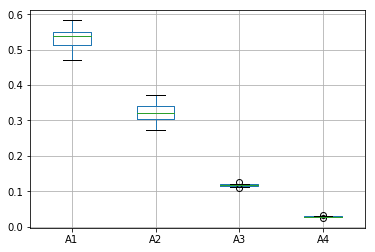

In [83]:
pris = pw.sim_priority(10)
prisdf = pd.DataFrame(data=pris, columns=["A1", "A2", "A3", "A4"])
prisdf.boxplot()

In [84]:
pw.sim_priority(1)

array([0.57018284, 0.28470598, 0.11949622, 0.02561496])

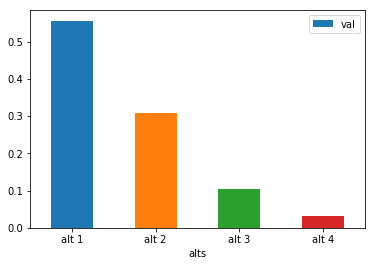

In [85]:
v=pw.sim_priority(1)
plot_sim(v, pw.alt_names())

[0.54725231 0.30404629 0.12094649 0.02775491]


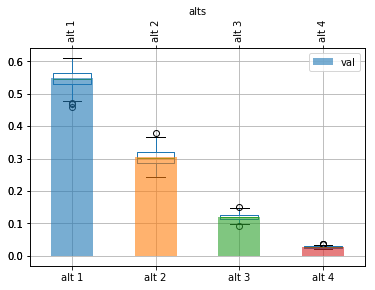

In [86]:
v=pw.sim_priority(size=200)
plot_sim(v, pw.alt_names())

[1.         0.55927169 0.22202898 0.05104681]


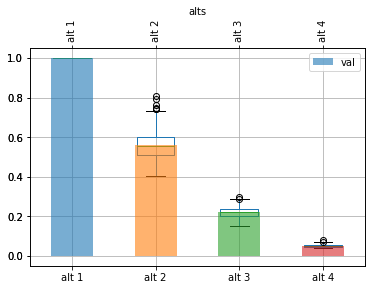

In [87]:
plot_sim(v, pw.alt_names(), idealize=True)

In [88]:
apw = np.array([
    [0, -1, 2],
    [-1., 0, 4],
    [-2, -4., 0]
], dtype=int)
arpw = RPairwiseMatrix.from_lscale_nparray(apw)
arpw.sim_priority(20)

array([[0.34318465, 0.53944545, 0.11736991],
       [0.31000794, 0.57186974, 0.11812232],
       [0.41084809, 0.47752377, 0.11162814],
       [0.37769489, 0.51973397, 0.10257114],
       [0.45044632, 0.44344528, 0.1061084 ],
       [0.35027952, 0.54498754, 0.10473294],
       [0.42791499, 0.47281937, 0.09926564],
       [0.40640233, 0.47550708, 0.11809059],
       [0.46523455, 0.41520659, 0.11955886],
       [0.47064681, 0.40805593, 0.12129726],
       [0.45275139, 0.42753052, 0.11971809],
       [0.40144109, 0.46977787, 0.12878104],
       [0.39898566, 0.46526724, 0.1357471 ],
       [0.41020261, 0.45905074, 0.13074665],
       [0.41536715, 0.44901042, 0.13562243],
       [0.50191863, 0.38182416, 0.11625721],
       [0.45370601, 0.42171421, 0.12457978],
       [0.41488604, 0.47319741, 0.11191655],
       [0.38672353, 0.51016186, 0.10311461],
       [0.44278949, 0.43810175, 0.11910876]])

In [89]:
mpw = np.array([
    [1, 2, 3],
    [1/2, 1, 5],
    [1/3, 1/5, 1]
])
mrpw = RPairwiseMatrix.from_mscale_nparray(mpw)

In [90]:
mrpw.sim()

array([[1.        , 2.57527176, 3.23294238],
       [0.38830853, 1.        , 5.43236752],
       [0.30931575, 0.1840818 , 1.        ]])

In [91]:
mrpw.set(0,1, -6.5)

AttributeError: 'RPairwiseMatrix' object has no attribute 'set'

In [ ]:
mrpw.sim_priority(20)